In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_squared_error
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, roc_auc_score

df = pd.read_csv("tech_jobs.csv")  # adjust path if needed
df.rename(columns={"clean_text": "requirement"}, inplace=True)
df.head()

,requirement,suspicious_score,is_vague,compensation,is_scam
0,copier technician east coast copier office equ...,0,0,Starting at $25/hour Negotiable with experience,0
1,matchmaking search assistant want high profile...,0,0,up to $16.50/hour,0
2,support technician electro mechanical scantech...,1,0,competitive,0
3,immediate hire hvac master license holder hvac...,1,0,Negotiable Competitive compensation,1
4,computer expert need help access information s...,0,1,Willing to pay solid money for a computer expe...,1


In [22]:
#Hold out method to split the data 

X = df['requirement']
y = df['is_scam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

print("Text Shapes:", X.shape, X_train.shape, X_test.shape)
print("Label Shapes:", y.shape, y_train.shape, y_test.shape)

Text Shapes: (383,) (306,) (77,)
Label Shapes: (383,) (306,) (77,)


In [23]:
# Text vectorization

vectorizer = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [24]:
# Logistic Regression model

log_model = LogisticRegression()
log_model.fit(X_train_vec, y_train)

train_preds = log_model.predict(X_train_vec)
test_preds = log_model.predict(X_test_vec)

print("LogReg Train Accuracy:", accuracy_score(y_train, train_preds))
print("LogReg Test Accuracy:", accuracy_score(y_test, test_preds))

LogReg Train Accuracy: 0.8235294117647058
LogReg Test Accuracy: 0.8571428571428571


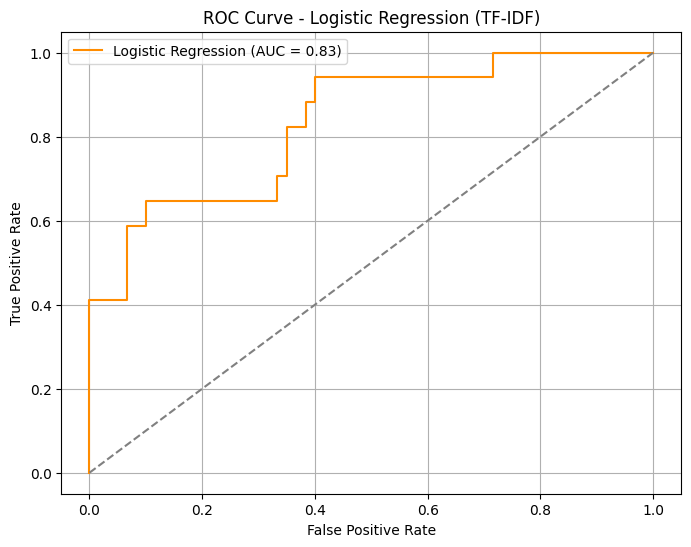

In [25]:
# ROC Curve

# Get predicted probabilities (not class labels)
y_probs = log_model.predict_proba(X_test_vec)[:, 1]  

# Compute False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_probs)

# 4. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (TF-IDF)')
plt.legend()
plt.grid(True)
plt.show()

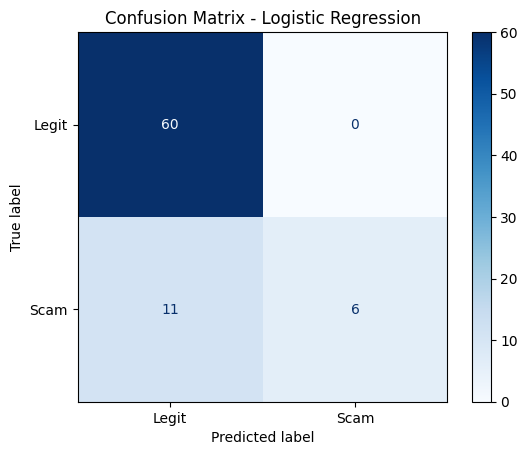

In [9]:
# Confusion matrix for Logistic Regression

cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Scam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Improved LogReg Train Accuracy: 0.9281045751633987
Improved LogReg Test Accuracy: 0.8311688311688312


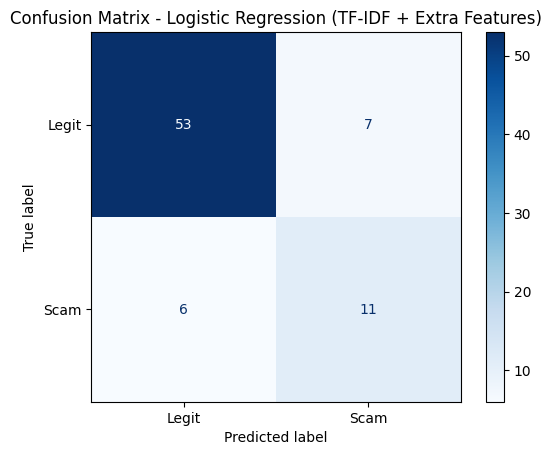

In [12]:
# TF-IDF + EXTRA FEATURES (still logistic regression)

vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    max_features=5000
)

X_train_text = vectorizer.fit_transform(X_train)
X_test_text = vectorizer.transform(X_test)

# Add numerical features
numeric_train = df.loc[X_train.index, ["suspicious_score", "is_vague"]].values
numeric_test = df.loc[X_test.index, ["suspicious_score", "is_vague"]].values

# Combine sparse text features with numerical ones
X_train_with_features = hstack([X_train_text, numeric_train])
X_test_with_features = hstack([X_test_text, numeric_test])

# Train improved model
model_with_features = LogisticRegression(class_weight='balanced', max_iter=1000)
model_with_features.fit(X_train_with_features, y_train)

# Evaluate
train_preds = model_with_features.predict(X_train_with_features)
test_preds = model_with_features.predict(X_test_with_features)

print("Improved LogReg Train Accuracy:", accuracy_score(y_train, train_preds))
print("Improved LogReg Test Accuracy:", accuracy_score(y_test, test_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Scam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (TF-IDF + Extra Features)")
plt.show()

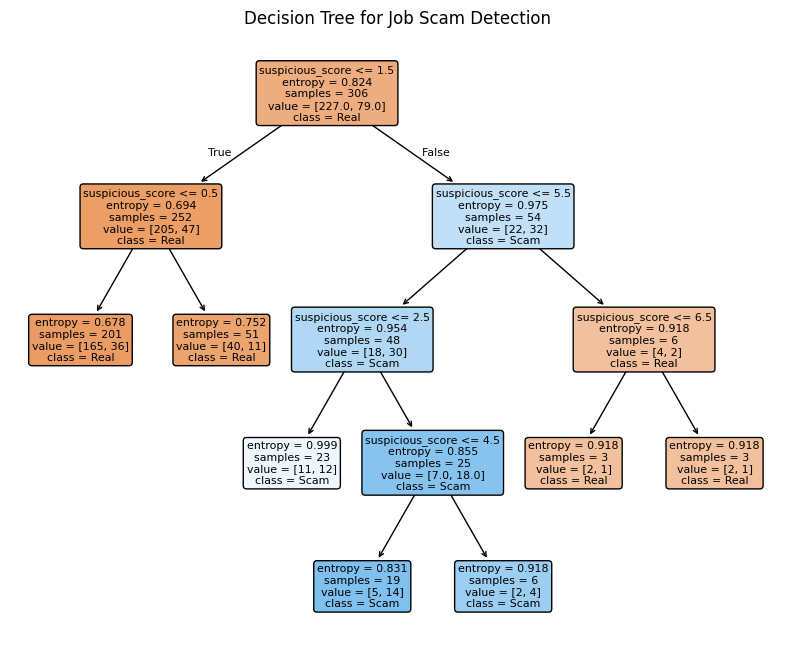

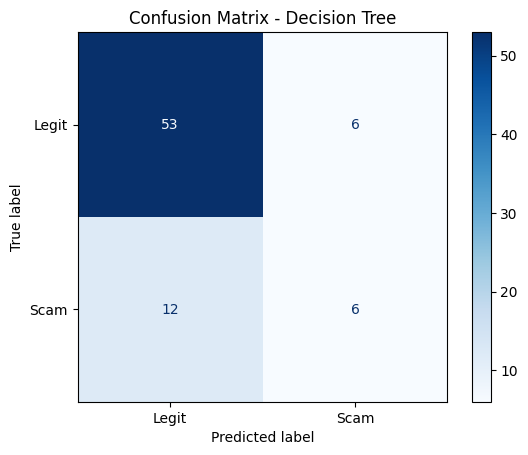

Accuracy: 0.7662337662337663
Recall: 0.3333333333333333
F1 Score: 0.4


In [27]:
# Simple Decision Tree on 'suspicious_score'

x = df[['suspicious_score']].copy()
y = df['is_scam']

le = LabelEncoder()
x['suspicious_score'] = le.fit_transform(x['suspicious_score'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf.fit(x_train, y_train)

plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=x.columns, class_names=['Real', 'Scam'], filled=True, rounded=True)
plt.title("Decision Tree for Job Scam Detection")
plt.show()

# Evaluate
y_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Legit", "Scam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Fold 1
Accuracy: 0.792, Recall: 0.263, F1: 0.385, MSE: 0.208

Fold 2
Accuracy: 0.844, Recall: 0.450, F1: 0.600, MSE: 0.156

Fold 3
Accuracy: 0.844, Recall: 0.400, F1: 0.571, MSE: 0.156

Fold 4
Accuracy: 0.829, Recall: 0.316, F1: 0.480, MSE: 0.171

Fold 5
Accuracy: 0.855, Recall: 0.474, F1: 0.621, MSE: 0.145

Average Metrics for Random Forest:
Accuracy: 0.833
Recall: 0.381
F1 Score: 0.531
MSE: 0.167


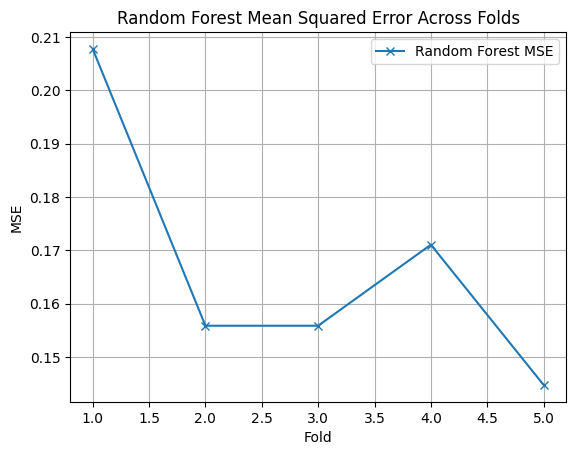

In [28]:
X_text = df['requirement']
y = df['is_scam'].values
X_num = df[['suspicious_score', 'is_vague']].values

vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    max_features=5000
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_accuracies, rf_recalls, rf_f1s, rf_mses = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_text, y)):
    print(f"\nFold {fold + 1}")
    X_train_text = vectorizer.fit_transform(X_text.iloc[train_idx])
    X_test_text = vectorizer.transform(X_text.iloc[test_idx])
    X_train_num = X_num[train_idx]
    X_test_num = X_num[test_idx]
    X_train_comb = hstack([X_train_text, X_train_num])
    X_test_comb = hstack([X_test_text, X_test_num])
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf_model.fit(X_train_comb, y_train)
    y_pred_rf = rf_model.predict(X_test_comb)

    rf_accuracies.append(accuracy_score(y_test, y_pred_rf))
    rf_recalls.append(recall_score(y_test, y_pred_rf))
    rf_f1s.append(f1_score(y_test, y_pred_rf))
    rf_mses.append(mean_squared_error(y_test, y_pred_rf))

    print(f"Accuracy: {rf_accuracies[-1]:.3f}, Recall: {rf_recalls[-1]:.3f}, F1: {rf_f1s[-1]:.3f}, MSE: {rf_mses[-1]:.3f}")

print("\nAverage Metrics for Random Forest:")
print(f"Accuracy: {np.mean(rf_accuracies):.3f}")
print(f"Recall: {np.mean(rf_recalls):.3f}")
print(f"F1 Score: {np.mean(rf_f1s):.3f}")
print(f"MSE: {np.mean(rf_mses):.3f}")

plt.plot(range(1, 6), rf_mses, marker='x', label="Random Forest MSE")
plt.title("Random Forest Mean Squared Error Across Folds")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

Model Comparison with 5-Fold Cross-Validation using TF-IDF + Numerical Features (Scam Detection)
Models: Logistic Regression, Random Forest, Decision Tree

In [13]:
# Prepare inputs
X_text = df['requirement']
y = df['is_scam'].values
X_num = df[['suspicious_score', 'is_vague']].values

# TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    max_features=5000
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
# Prepare metrics
logistic_accuracies, logistic_recalls, logistic_f1s, logistic_mses = [], [], [], []
rf_accuracies, rf_recalls, rf_f1s, rf_mses = [], [], [], []
dt_accuracies, dt_recalls, dt_f1s, dt_mses = [], [], [], []

In [15]:
for fold, (train_idx, test_idx) in enumerate(kf.split(X_text, y)):
    print(f"\n Fold {fold + 1}")

    # Text and numerical features
    X_train_text = vectorizer2.fit_transform(X_text.iloc[train_idx])
    X_test_text = vectorizer2.transform(X_text.iloc[test_idx])
    X_train_num = X_num[train_idx]
    X_test_num = X_num[test_idx]

    # Combine them
    X_train_comb = hstack([X_train_text, X_train_num])
    X_test_comb = hstack([X_test_text, X_test_num])
    y_train = y[train_idx]
    y_test = y[test_idx]

    # Logistic Regression
    log_model = LogisticRegression(C=5.0, class_weight='balanced', max_iter=1000)
    log_model.fit(X_train_comb, y_train)
    y_pred_log = log_model.predict(X_test_comb)

    logistic_accuracies.append(accuracy_score(y_test, y_pred_log))
    logistic_recalls.append(recall_score(y_test, y_pred_log))
    logistic_f1s.append(f1_score(y_test, y_pred_log))
    logistic_mses.append(mean_squared_error(y_test, y_pred_log))

    print(f"Logistic → Acc: {logistic_accuracies[-1]:.3f}, Rec: {logistic_recalls[-1]:.3f}, F1: {logistic_f1s[-1]:.3f}, MSE: {logistic_mses[-1]:.3f}")

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf_model.fit(X_train_comb, y_train)
    y_pred_rf = rf_model.predict(X_test_comb)

    rf_accuracies.append(accuracy_score(y_test, y_pred_rf))
    rf_recalls.append(recall_score(y_test, y_pred_rf))
    rf_f1s.append(f1_score(y_test, y_pred_rf))
    rf_mses.append(mean_squared_error(y_test, y_pred_rf))

    print(f"Random Forest → Acc: {rf_accuracies[-1]:.3f}, Rec: {rf_recalls[-1]:.3f}, F1: {rf_f1s[-1]:.3f}, MSE: {rf_mses[-1]:.3f}")

    # Decision Tree
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
    dt_model.fit(X_train_comb, y_train)
    y_pred_dt = dt_model.predict(X_test_comb)

    dt_accuracies.append(accuracy_score(y_test, y_pred_dt))
    dt_recalls.append(recall_score(y_test, y_pred_dt))
    dt_f1s.append(f1_score(y_test, y_pred_dt))
    dt_mses.append(mean_squared_error(y_test, y_pred_dt))

    print(f"Decision Tree → Acc: {dt_accuracies[-1]:.3f}, Rec: {dt_recalls[-1]:.3f}, F1: {dt_f1s[-1]:.3f}, MSE: {dt_mses[-1]:.3f}")



 Fold 1
Logistic → Acc: 0.857, Rec: 0.684, F1: 0.703, MSE: 0.143
Random Forest → Acc: 0.792, Rec: 0.263, F1: 0.385, MSE: 0.208
Decision Tree → Acc: 0.766, Rec: 0.632, F1: 0.571, MSE: 0.234

 Fold 2
Logistic → Acc: 0.792, Rec: 0.600, F1: 0.600, MSE: 0.208
Random Forest → Acc: 0.844, Rec: 0.450, F1: 0.600, MSE: 0.156
Decision Tree → Acc: 0.805, Rec: 0.650, F1: 0.634, MSE: 0.195

 Fold 3
Logistic → Acc: 0.883, Rec: 0.600, F1: 0.727, MSE: 0.117
Random Forest → Acc: 0.844, Rec: 0.400, F1: 0.571, MSE: 0.156
Decision Tree → Acc: 0.805, Rec: 0.600, F1: 0.615, MSE: 0.195

 Fold 4
Logistic → Acc: 0.882, Rec: 0.684, F1: 0.743, MSE: 0.118
Random Forest → Acc: 0.829, Rec: 0.316, F1: 0.480, MSE: 0.171
Decision Tree → Acc: 0.829, Rec: 0.579, F1: 0.629, MSE: 0.171

 Fold 5
Logistic → Acc: 0.882, Rec: 0.684, F1: 0.743, MSE: 0.118
Random Forest → Acc: 0.855, Rec: 0.474, F1: 0.621, MSE: 0.145
Decision Tree → Acc: 0.816, Rec: 0.632, F1: 0.632, MSE: 0.184


In [16]:
# Final Averages
print("\n Final K-Fold Averages:")
print(f"Logistic      → Accuracy: {np.mean(logistic_accuracies):.3f}, Recall: {np.mean(logistic_recalls):.3f}, F1: {np.mean(logistic_f1s):.3f}, MSE: {np.mean(logistic_mses):.3f}")
print(f"Random Forest → Accuracy: {np.mean(rf_accuracies):.3f}, Recall: {np.mean(rf_recalls):.3f}, F1: {np.mean(rf_f1s):.3f}, MSE: {np.mean(rf_mses):.3f}")
print(f"Decision Tree → Accuracy: {np.mean(dt_accuracies):.3f}, Recall: {np.mean(dt_recalls):.3f}, F1: {np.mean(dt_f1s):.3f}, MSE: {np.mean(dt_mses):.3f}")



 Final K-Fold Averages:
Logistic      → Accuracy: 0.859, Recall: 0.651, F1: 0.703, MSE: 0.141
Random Forest → Accuracy: 0.833, Recall: 0.381, F1: 0.531, MSE: 0.167
Decision Tree → Accuracy: 0.804, Recall: 0.618, F1: 0.616, MSE: 0.196


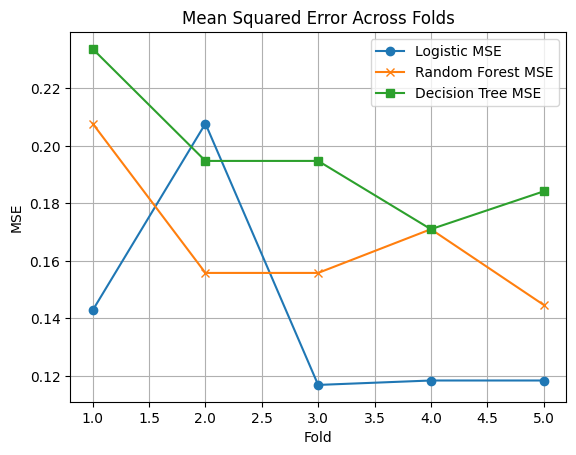

In [17]:
# Plot MSE
plt.plot(range(1, 6), logistic_mses, marker='o', label="Logistic MSE")
plt.plot(range(1, 6), rf_mses, marker='x', label="Random Forest MSE")
plt.plot(range(1, 6), dt_mses, marker='s', label="Decision Tree MSE")
plt.title("Mean Squared Error Across Folds")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


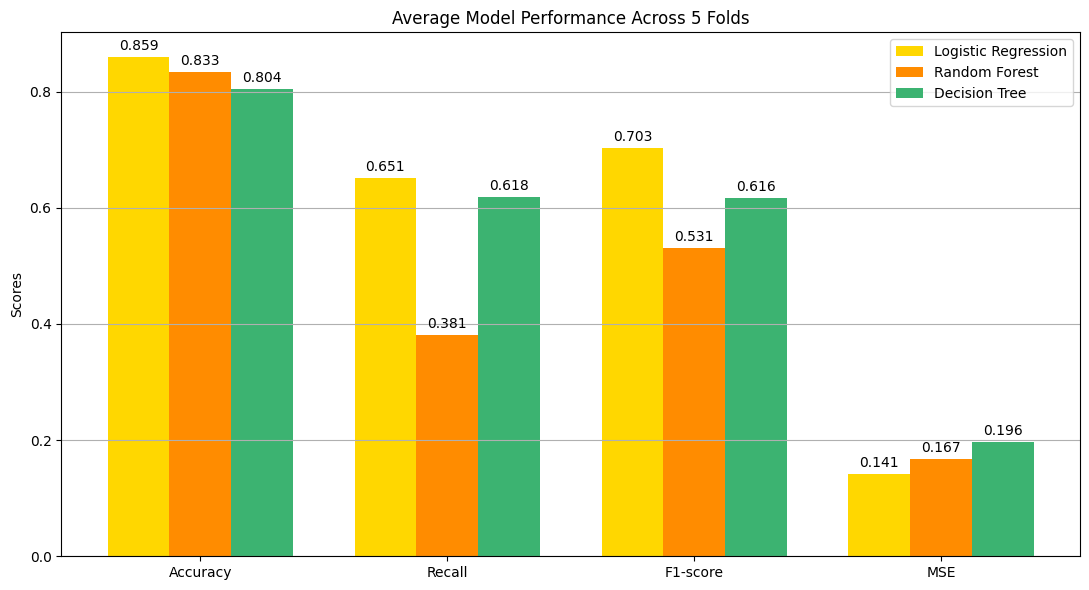

In [18]:
# Labels and metric names
labels = ['Accuracy', 'Recall', 'F1-score', 'MSE']
x = np.arange(len(labels))
width = 0.25

# Final average scores (example values, replace if needed)
logistic_scores = [0.859, 0.651, 0.703, 0.141]
rf_scores       = [0.833, 0.381, 0.531, 0.167]
dt_scores       = [0.804, 0.618, 0.616, 0.196]

# Create bar chart
fig, ax = plt.subplots(figsize=(11, 6))
bars1 = ax.bar(x - width, logistic_scores, width, label='Logistic Regression', color='gold')
bars2 = ax.bar(x, rf_scores, width, label='Random Forest', color='darkorange')
bars3 = ax.bar(x + width, dt_scores, width, label='Decision Tree', color='mediumseagreen')

# Labels and title
ax.set_ylabel('Scores')
ax.set_title('Average Model Performance Across 5 Folds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')

# Add value labels on top of bars
for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
# Analyzing Most Important Terms from Scam Descriptions

# Filter only scam jobs
fraudulent_jobs = df[df['is_scam'] == 1]

# Use the 'requirement' column (cleaned text)
text_data = fraudulent_jobs['requirement'].fillna('')

# Create and apply TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
X_tfidf = vectorizer.fit_transform(text_data)

# Extract feature names and average TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
mean_scores = X_tfidf.mean(axis=0).A1  # Flatten sparse matrix

# Create a DataFrame of top words
tfidf_df = pd.DataFrame({'word': feature_names, 'score': mean_scores})
top_words = tfidf_df.sort_values(by='score', ascending=False).reset_index(drop=True)

# Display top 20 words
top_words.head(20)

,word,score
0,work,0.161637
1,earn,0.114066
2,experience,0.108282
3,time,0.101985
4,pay,0.100578
5,look,0.098540
6,need,0.096994
7,team,0.088486
8,help,0.086846
9,hour,0.081477


In [29]:
import joblib

# Save Logistic Regression model
joblib.dump(log_model, "logistic_model.joblib")

# Save Random Forest model
joblib.dump(rf_model, "random_forest_model.joblib")

# Save Decision Tree model (clf or dt_model, depending on your variable name)
joblib.dump(clf, "decision_tree_model.joblib")

# Save the TF-IDF vectorizer (use the exact one trained with the model)
joblib.dump(vectorizer2, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']